📂 발견된 파일 9개: ['bike_weather_2017.csv', 'bike_weather_2018.csv', 'bike_weather_2019.csv', 'bike_weather_2020.csv', 'bike_weather_2021.csv', 'bike_weather_2022.csv', 'bike_weather_2023.csv', 'bike_weather_2024.csv', 'bike_weather_2025.csv']


파일 읽는 중: 100%|██████████| 9/9 [03:20<00:00, 22.25s/it]



🔄 전체 데이터 병합 중...
🛠️ 결측치 전처리 수행 중...


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_25332\3393850190.py:92: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df[col] = full_df[col].fillna(method='ffill').fillna(method='bfill')


📊 데이터 집계 중 (Grouping)...
✅ 데이터 로드 완료! 크기: (72942, 9)
💾 'base_data.csv' 저장 완료 (Feature Engineering 전 단계)

🔍 EDA를 위한 임시 변수 생성 중...


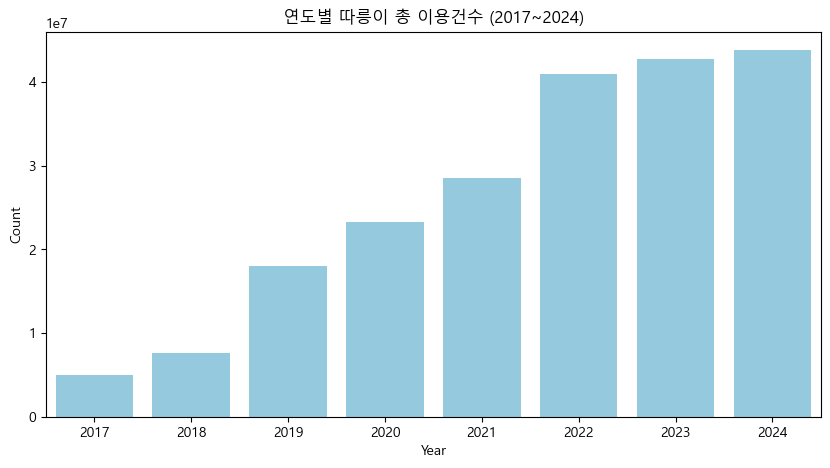

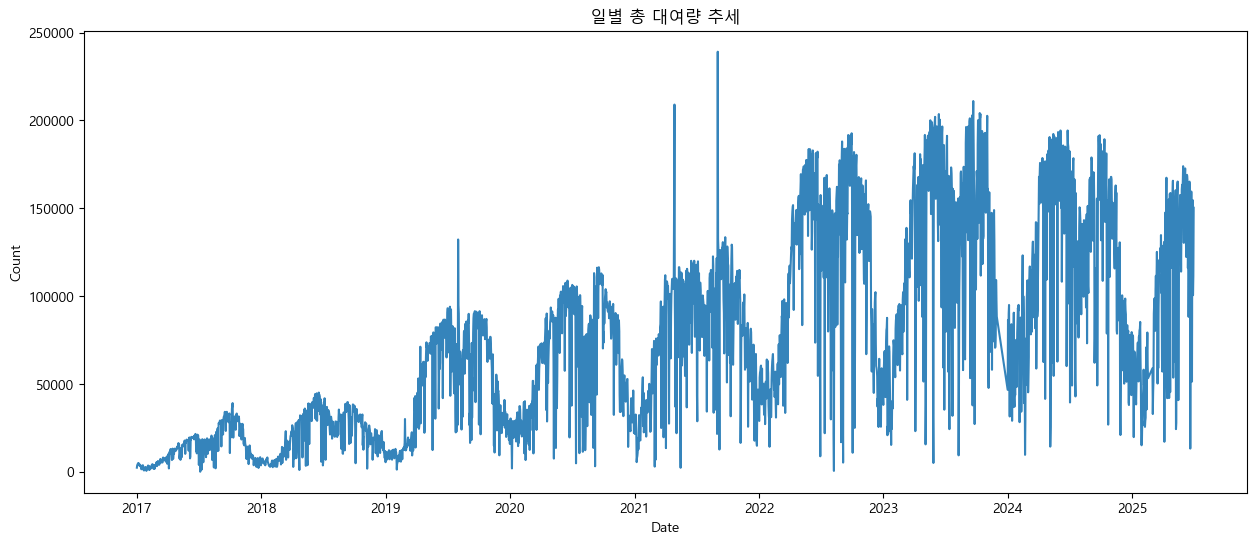


📊 Sweetviz 리포트 생성 중...


                                             |          | [  0%]   00:00 -> (? left)

Report Sweetviz_Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
✅ 리포트 생성 완료


In [1]:
# ---------------------------------------------------------
# [필수] 라이브러리 설치
# ---------------------------------------------------------
!pip install sweetviz tqdm

import pandas as pd
import numpy as np

# Sweetviz - Numpy 호환성 패치
if not hasattr(np, 'VisibleDeprecationWarning'):
    np.VisibleDeprecationWarning = UserWarning

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import platform
import sweetviz as sv
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# 폰트 설정
system_name = platform.system()
if system_name == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif system_name == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 1. 데이터 로드 및 집계 함수 (순수 데이터 처리 위주)
# ---------------------------------------------------------
def load_and_aggregate_data():
    files = glob.glob('bike_weather_*.csv')
    
    if not files:
        print("❌ 오류: 'bike_weather_*.csv' 파일을 찾을 수 없습니다.")
        return None

    print(f"📂 발견된 파일 {len(files)}개: {sorted(files)}")
    
    df_list = []
    
    for f in tqdm(sorted(files), desc="파일 읽는 중"):
        try:
            try:
                temp = pd.read_csv(f, encoding='cp949', low_memory=False)
            except:
                temp = pd.read_csv(f, encoding='utf-8', low_memory=False)
            
            temp.columns = temp.columns.str.strip()
            
            cols_to_keep = [
                '대여일자', '대여시간', '이용건수',
                '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '적설(cm)', 
                '시정(10m)'
            ]
            
            existing_cols = [c for c in cols_to_keep if c in temp.columns]
            temp = temp[existing_cols]
            
            if '이용건수' in temp.columns and temp['이용건수'].dtype == object:
                temp['이용건수'] = temp['이용건수'].astype(str).str.replace(',', '').astype(float)
                
            df_list.append(temp)
            
        except Exception as e:
            print(f"⚠️ 파일 에러 {f}: {e}")
            
    if not df_list:
        return None

    print("\n🔄 전체 데이터 병합 중...")
    full_df = pd.concat(df_list, ignore_index=True)
    
    # 전처리 및 결측치 보정
    print("🛠️ 결측치 전처리 수행 중...")
    full_df['대여일자'] = pd.to_datetime(full_df['대여일자'])
    full_df.sort_values(by=['대여일자', '대여시간'], inplace=True)
    
    zero_fill_cols = ['강수량(mm)', '적설(cm)']
    for col in zero_fill_cols:
        if col in full_df.columns:
            full_df[col] = full_df[col].fillna(0)
            
    weather_cols = ['기온(°C)', '풍속(m/s)', '습도(%)', '시정(10m)']
    for col in weather_cols:
        if col in full_df.columns:
            full_df[col] = full_df[col].interpolate(method='linear', limit_direction='both')
            full_df[col] = full_df[col].fillna(method='ffill').fillna(method='bfill')

    print("📊 데이터 집계 중 (Grouping)...")
    agg_rules = {
        '이용건수': 'sum', '기온(°C)': 'mean', '강수량(mm)': 'mean',
        '풍속(m/s)': 'mean', '습도(%)': 'mean', '적설(cm)': 'mean', '시정(10m)': 'mean'
    }
    final_agg = {k: v for k, v in agg_rules.items() if k in full_df.columns}
    
    df_grouped = full_df.groupby(['대여일자', '대여시간']).agg(final_agg).reset_index()
    
    rename_map = {
        '대여일자': 'Date', '대여시간': 'Hour', '이용건수': 'Count',
        '기온(°C)': 'Temp', '강수량(mm)': 'Rain', '풍속(m/s)': 'Wind',
        '습도(%)': 'Humidity', '적설(cm)': 'Snow', '시정(10m)': 'Visibility'
    }
    df_grouped.rename(columns=rename_map, inplace=True)
    df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])
    df_grouped.fillna(0, inplace=True)
    
    return df_grouped

# ---------------------------------------------------------
# 2. 실행 및 기본 데이터 저장
# ---------------------------------------------------------
df_base = load_and_aggregate_data()

if df_base is not None:
    print(f"✅ 데이터 로드 완료! 크기: {df_base.shape}")
    
    # [중요] 여기서는 파생 변수 없이 '순수 데이터'만 저장합니다.
    df_base.to_csv('base_data.csv', index=False)
    print("💾 'base_data.csv' 저장 완료 (Feature Engineering 전 단계)")

    # ---------------------------------------------------------
    # 3. EDA용 임시 변수 생성 (시각화 목적)
    # ---------------------------------------------------------
    # 주의: 이 변수들은 분석용으로만 쓰고 파일엔 저장하지 않았습니다.
    print("\n🔍 EDA를 위한 임시 변수 생성 중...")
    eda_df = df_base.copy()
    eda_df['Year'] = eda_df['Date'].dt.year
    eda_df['Temphumidity'] = eda_df['Temp'] * eda_df['Humidity']

    # 시각화 1: 연도별 총량 (2025 제외)
    plt.figure(figsize=(10, 5))
    df_full_years = eda_df[eda_df['Year'] < 2025] 
    sns.barplot(data=df_full_years, x='Year', y='Count', estimator='sum', errorbar=None, color='skyblue')
    plt.title("연도별 따릉이 총 이용건수 (2017~2024)")
    plt.show()

    # 시각화 2: 일별 추세
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=eda_df, x='Date', y='Count', estimator='sum', errorbar=None, color='#1f77b4', alpha=0.9)
    plt.title("일별 총 대여량 추세")
    plt.show()

    # Sweetviz 리포트
    print("\n📊 Sweetviz 리포트 생성 중...")
    train_df, test_df = train_test_split(eda_df, test_size=0.2, random_state=42)
    report = sv.compare([train_df, "Train"], [test_df, "Test"], target_feat='Count')
    report.show_html('Sweetviz_Report.html')
    print("✅ 리포트 생성 완료")

else:
    print("데이터 로드 실패")